<a href="https://colab.research.google.com/github/sufaye2024/bhban_rpa/blob/master/2024_dh__004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 토픽 모델링을 이용한 연구 동향 분석
토픽 모델링을 사용해 특정 분야의 연구 동향을 분석하는 방법을 실습합니다.
논문의 제목과 초록, 발행연도, 저널이 들어간 말뭉치를 G-DMR로 처리하여 저널별 주제 분포, 발행연도별 주제 분포를 살펴봅니다.


In [ ]:
# 파이썬 패키지 설치
!pip install kiwipiepy tomotopy nltk pandas

# 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 이 셀을 실행 후 메뉴의 [런타임] - [런타임 다시 시작](또는 [세션 다시 시작])을 클릭하여 재시작해야 한글 폰트 설치가 마무리됩니다.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kiwipiepy-model: filename=kiwipiepy_model-0.16.0-py3-none-any.whl size=30813256 sha256=5edf191479ab1f83c210294ac58ef4b0e2565fe767e7670b2bcd3b704ac39be7
  Stored in directory: /root/.cache/pip/wheels/6b/03/2b/ac2c97cc65ebd9df3516f4b900adc2f0a744df8d1375b2e2ef
Successfully built kiwipiepy-model
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 202005

In [ ]:
import kiwipiepy
import tomotopy as tp
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 엑셀 시트에 있는 데이터셋 읽어오기

In [ ]:
# 구글 드라이브에서 lis_journal.xlsx를 가져옵니다.
# 혹은 https://drive.google.com/file/d/167I3u4spfGGyzvshgjPOaXqtn_bE74Xy/view?usp=drive_link 에서 파일을 다운받은뒤
# 직접 업로드하는 방법도 가능합니다.
FILEID = "167I3u4spfGGyzvshgjPOaXqtn_bE74Xy"
FILENAME = "lis_journal.xlsx"

!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILEID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILEID}" -O {FILENAME} && rm -rf ~/cookies.txt

--2024-01-15 07:03:38--  https://docs.google.com/uc?export=download&confirm=&id=167I3u4spfGGyzvshgjPOaXqtn_bE74Xy
Resolving docs.google.com (docs.google.com)... 172.217.15.238, 2607:f8b0:4025:802::200e
Connecting to docs.google.com (docs.google.com)|172.217.15.238|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=167I3u4spfGGyzvshgjPOaXqtn_bE74Xy&export=download [following]
--2024-01-15 07:03:38--  https://drive.usercontent.google.com/download?id=167I3u4spfGGyzvshgjPOaXqtn_bE74Xy&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.12.1, 2607:f8b0:4025:815::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.12.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929144 (907K) [application/octet-stream]
Saving to: ‘lis_journal.xlsx’

lis_journal.xlsx    100%[===================>] 907.37K  --.-KB/s    in 0

In [ ]:
# pd.read_excel을 이용해서 엑셀 파일에 있는 데이터를 읽어옵니다.
df = pd.read_excel('lis_journal.xlsx')

In [ ]:
# 잘 읽어와졌는지 출력해봅니다.
df

,Journal,Year,Title,Abstract
0,한국기록관리학회지,2023,영미권 국립보존기록관 인스타그램의 기록정보콘텐츠 사례 연구,본 연구의 목적은 영미권 국립보존기록관 인스타그램의 기록정보콘텐츠 사례를 분석하여 ...
1,한국기록관리학회지,2023,행정정보 데이터세트 평가선별을 위한 평가지표 개선방안 연구,국내 공공기관에서 행정정보 데이터세트는 체계적인 관리가 필요한 전자기록물로 인식된다...
2,한국기록관리학회지,2023,영화 효과음원 온라인 서비스 개선방안 연구 : K-Sound Library 를 중심으로,최근 국내 영화산업은 세계적으로 유명한 영화제의 주요상을 수상하면서 전성기를 맞이하...
3,한국기록관리학회지,2023,지방자치단체의 지역 기록화 사업 현황과 지속가능성 검토,본 연구는 지방자치단체가 수행한 지역 기록화 사업의 제도 및 운영 현황을 파악하고 ...
4,한국기록관리학회지,2023,국채보상운동 디지털 아카이브 기록물의 활용을 위한 위키데이터 연계 방안에 대한 연구,본 연구는 세계기록유산으로 등재된 국채보상운동 디지털 아카이브 기록물의 활용성을 높...
...,...,...,...,...
2103,정보관리학회지,1984,이용자연구의 이론과 실제,이용자연구를 해야하는 근본적인 동기와 관련하여 정보이용행동에 영향을 주는 요인들을 ...
2104,정보관리학회지,1984,서지자료특성에 대한 이용자 반응 조사,정보가 폭증함에 따라 이용자로 하여금 필요한 정보에 접근할 수 있게 해주는 서지정보...
2105,정보관리학회지,1984,연구활동에 있어서의 비공식 커뮤니케이션,연구자들은 정보폭발에 대처하고 또 공식 커뮤니케이션으로 충족되지 않은 정보요구를 만...
2106,정보관리학회지,1984,SDI System의 사적연구(史的硏究)(1),오늘날 정보검색(情報檢索)시스팀의 대표적(代表的)인 한 유형(類型)으로서 널리 보급...


# 형태소 분석하기

In [ ]:
kiwi = kiwipiepy.Kiwi(num_workers=2)

In [ ]:
# Kiwi 형태소 분석기 기반의 토크나이저입니다.
class KoreanTokenizer:
    def __init__(self, kiwi, allowed_tags:list = None, banned_tags:list = None, stopwords:list = None):
        self.kiwi = kiwi
        assert allowed_tags is None or banned_tags is None, 'allowed_tags and banned_tags cannot be used at the same time.'
        self.allowed_tags = set(allowed_tags) if allowed_tags is not None else None
        self.banned_tags = set(banned_tags) if banned_tags is not None else None
        self.stopwords = set(stopwords or [])

    def __call__(self, texts):
        for tokens in self.kiwi.tokenize(text for text, _ in texts):
            if self.allowed_tags is not None:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tag in self.allowed_tags and token.tagged_form not in self.stopwords]
            elif self.banned_tags is not None:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tag not in self.banned_tags and token.tagged_form not in self.stopwords]
            else:
                tokens = [(token.tagged_form, token.start, token.len) for token in tokens if token.tagged_form not in self.stopwords]
            yield tokens

In [ ]:
# 형태소 분석기의 품사 태그에 관해서는
# https://github.com/bab2min/kiwipiepy?tab=readme-ov-file#%ED%92%88%EC%82%AC-%ED%83%9C%EA%B7%B8
# 를 참조해주세요.
tokenizer = KoreanTokenizer(
    kiwi,
    allowed_tags=['NNG', 'NNP',
                  'VV', 'VA',
                  'XR',
                  'SN', 'SL', 'SH'],
    stopwords=['하/VV', '되/VV', '이/MM', '그/MM', '저/MM']
)

In [ ]:
tokenized_samples = list(tokenizer((title + '\n' + content, None) for title, content in zip(df['Title'].head(10), df['Abstract'].head(10))))

In [ ]:
tokenized_samples

[[('영미/NNP', 0, 2),
  ('국립/NNG', 4, 2),
  ('보존/NNG', 6, 2),
  ('기록관/NNG', 8, 3),
  ('인스타그램/NNP', 12, 5),
  ('기록/NNG', 19, 2),
  ('정보/NNG', 21, 2),
  ('콘텐츠/NNG', 23, 3),
  ('사례/NNG', 27, 2),
  ('연구/NNG', 30, 2),
  ('연구/NNG', 35, 2),
  ('목적/NNG', 39, 2),
  ('영미/NNP', 43, 2),
  ('국립/NNG', 47, 2),
  ('보존/NNG', 49, 2),
  ('기록관/NNG', 51, 3),
  ('인스타그램/NNP', 55, 5),
  ('기록/NNG', 62, 2),
  ('정보/NNG', 64, 2),
  ('콘텐츠/NNG', 66, 3),
  ('사례/NNG', 70, 2),
  ('분석/NNG', 74, 2),
  ('국내/NNG', 79, 2),
  ('기록물/NNG', 82, 3),
  ('관리/NNG', 85, 2),
  ('기관/NNG', 87, 2),
  ('기록/NNG', 93, 2),
  ('정보/NNG', 95, 2),
  ('콘텐츠/NNG', 97, 3),
  ('개발/NNG', 101, 2),
  ('위하/VV', 105, 2),
  ('시사점/NNG', 108, 3),
  ('도출/NNG', 113, 2),
  ('위하/VV', 126, 2),
  ('연구/NNG', 129, 2),
  ('대상/NNG', 132, 2),
  ('인스타그램/NNP', 135, 5),
  ('개설/NNG', 142, 2),
  ('일/NNG', 144, 1),
  ('콘텐츠/NNG', 147, 3),
  ('수/NNG', 151, 1),
  ('팔/NNG', 154, 1),
  ('수/NNG', 164, 1),
  ('기본/NNG', 168, 2),
  ('현황/NNG', 170, 2),
  ('조사/NNG', 174, 2),
  ('팔로워/NN

In [ ]:
# 토픽 모델링에 사용할 문서들 전체를 Corpus로 묶습니다.
corpus = tp.utils.Corpus(tokenizer=tokenizer)
# 제목과 초록을 합쳐서 하나의 텍스트로 만들어서 입력합니다. (\n는 줄바꿈 문자를 뜻합니다.)
# Year는 연속형 정보이므로 numeric_metadata에 넣고
# Journal은 범주형 정보이므로 metadata에 넣습니다.
corpus.process((str(row['Title']) + '\n' + str(row['Abstract']), None, {'numeric_metadata':[row['Year']], 'metadata':row['Journal']}) for _, row in tqdm(df.iterrows(), total=len(df.index)))

100%|██████████| 2108/2108 [00:56<00:00, 37.36it/s]


2108

In [ ]:
# G-DMR 토픽 모델을 생성합니다.
# k: 주제의 개수. 연구자가 적절한 수치로 선택해야 합니다. 이에 대해서는 별도로 더 설명할 예정입니다.
# min_df: 이 숫자보다 적은 개수의 문서에만 등장하는 어휘는 학습에서 배제시킵니다.
#         극히 소수의 문서에서만 등장하는 어휘는 최종 결과에 노이즈로만 작용하므로 배제하는게 좋습니다.
# tw: 용어 가중치 부여 방법. tp.TermWeight.ONE, tp.TermWeight.IDF, tp.TermWeight.PMI 중 하나를 선택할 수 있습니다.
#     생략할 경우 tp.TermWeight.ONE이 기본값으로 선택됩니다.
# degrees: 연속형 메타데이터를 모델링할때 사용할 차수입니다. 0이면 상수, 1이면 선형, 2이면 이차식(포물선형) ...
#          차수가 높아질수록 더 복잡한 패턴을 모델링할 수 있지만 노이즈에 취약해지고 학습이 오래걸립니다.
model = tp.GDMRModel(k=20, min_df=2, tw=tp.TermWeight.ONE, degrees=[2], corpus=corpus)

In [ ]:
model.train(0)
model.summary(topic_word_top_n=10)

<Basic Info>
| GDMRModel (current version: 0.12.7)
| 2108 docs, 221557 words
| Total Vocabs: 11008, Used Vocabs: 4993
| Entropy of words: 6.74662
| Entropy of term-weighted words: 6.74662
| Removed Vocabs: <NA>
| Categorical metadata of docs and its distribution
|  한국기록관리학회지: 584
|  정보관리학회지: 1524
| Numeric metadata distribution of docs
|  #0: Range=1984.0~2023.0, Avg=2009.7, Stdev=8.8885
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -10.69496
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 2 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| degrees: [2] (a list of the degrees of Legendre polynomials for TDF(Topic Distribution Function))
| alpha: [0.1] (exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with

In [ ]:
model.train(2000, workers=2, show_progress=True)

Iteration: 100%|██████████| 2000/2000 [01:07<00:00, 29.82it/s, LLPW: -6.902280]


In [ ]:
model.summary(topic_word_top_n=10)

<Basic Info>
| GDMRModel (current version: 0.12.7)
| 2108 docs, 221557 words
| Total Vocabs: 11008, Used Vocabs: 4993
| Entropy of words: 6.74662
| Entropy of term-weighted words: 6.74662
| Removed Vocabs: <NA>
| Categorical metadata of docs and its distribution
|  한국기록관리학회지: 584
|  정보관리학회지: 1524
| Numeric metadata distribution of docs
|  #0: Range=1984.0~2023.0, Avg=2009.7, Stdev=8.8885
|
<Training Info>
| Iterations: 2000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.89799
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 0 (minimum collection frequency of words)
| min_df: 2 (minimum document frequency of words)
| rm_top: 0 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| degrees: [2] (a list of the degrees of Legendre polynomials for TDF(Topic Distribution Function))
| alpha: [0.1] (exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list wi

In [ ]:
start_year = 2000
end_year = 2023
dist_by_journal = []
for journal in model.metadata_dict:
  dist = model.tdf_linspace([start_year], [end_year], [end_year - start_year + 1], journal)
  dist_by_journal.append(dist)
dist_by_journal = np.stack(dist_by_journal, axis=0)

In [ ]:
# 한글 폰트 설정
# 한글 폰트 설치 후 이걸 설정하지 않으면 차트에서 한글이 전부 깨져서 렌더링됩니다.
plt.rc('font', family='NanumBarunGothic')

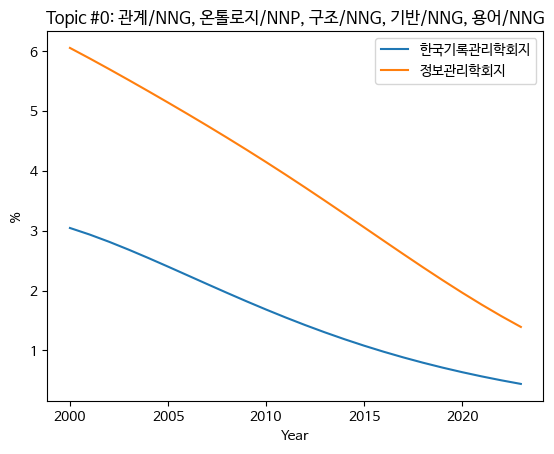

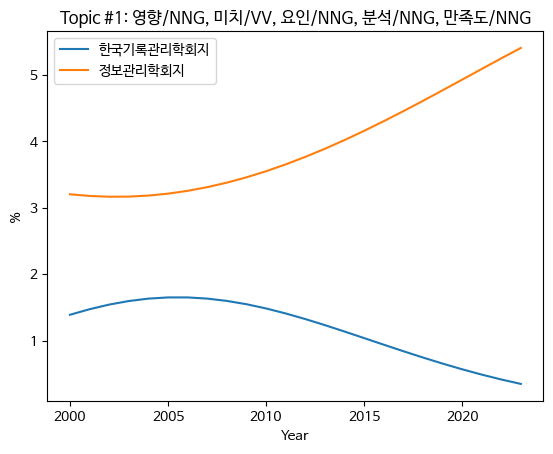

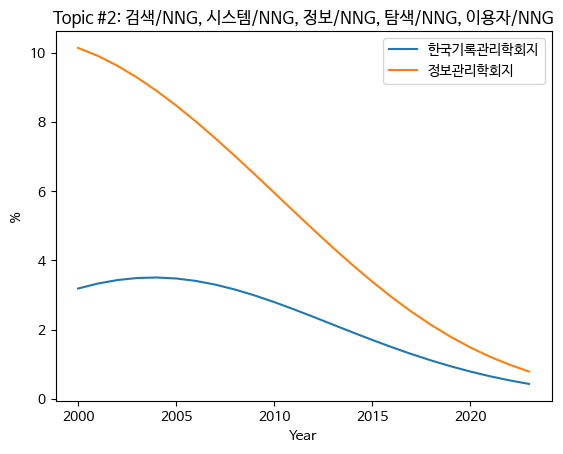

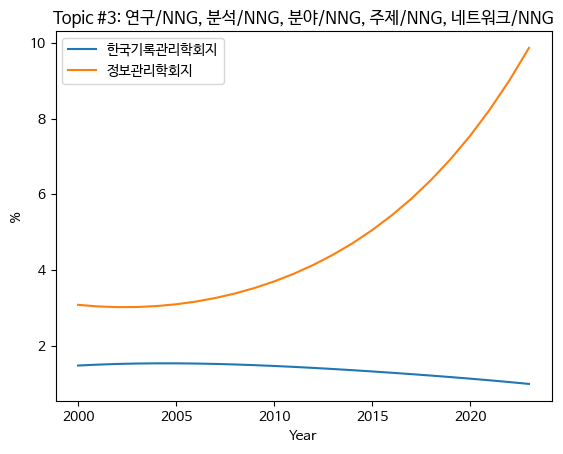

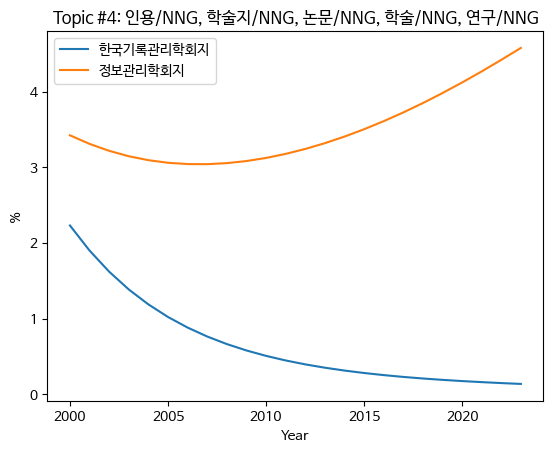

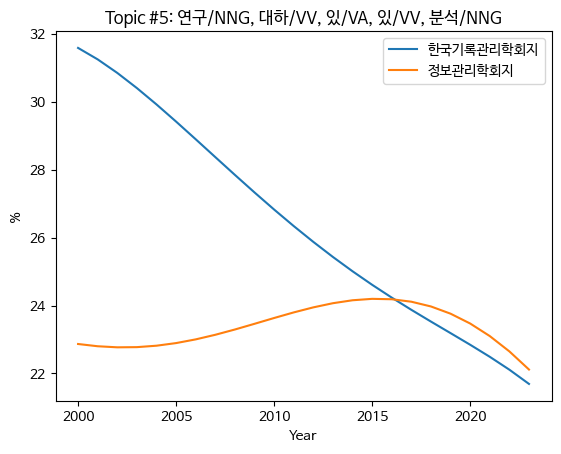

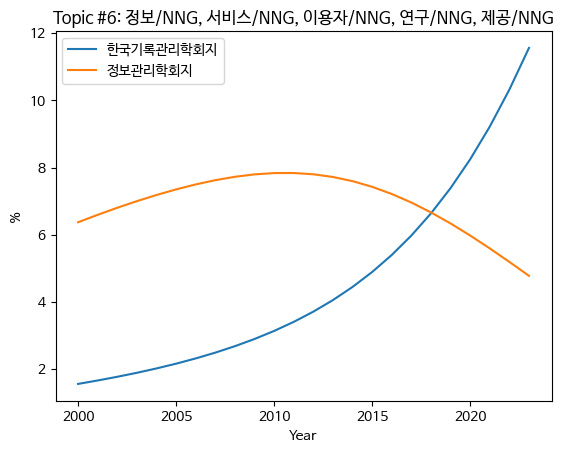

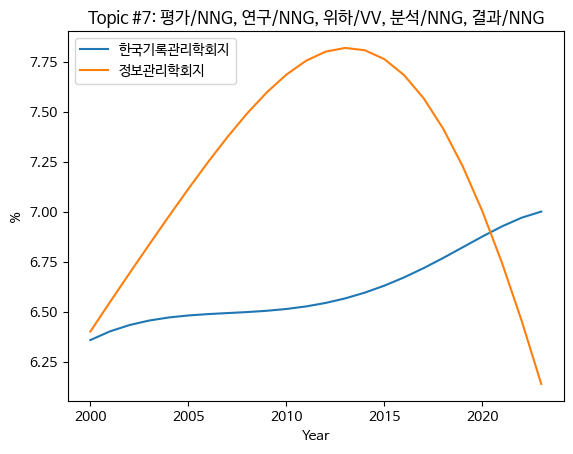

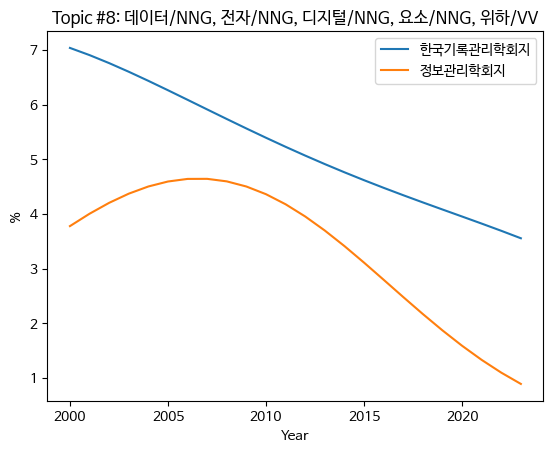

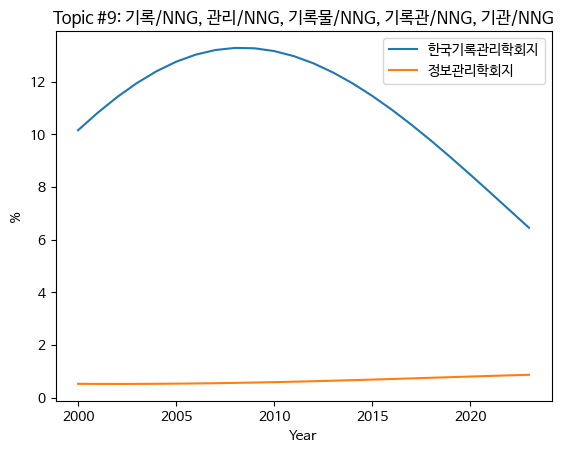

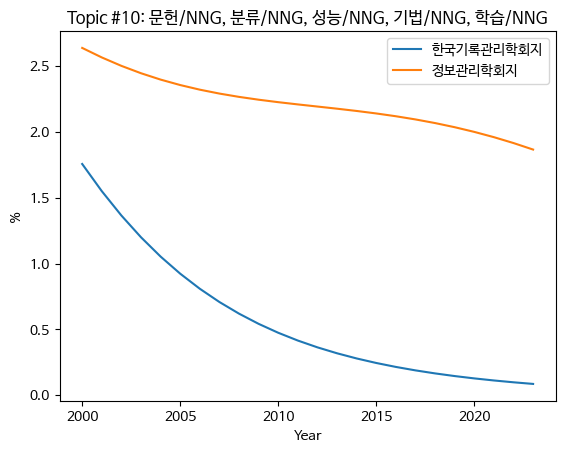

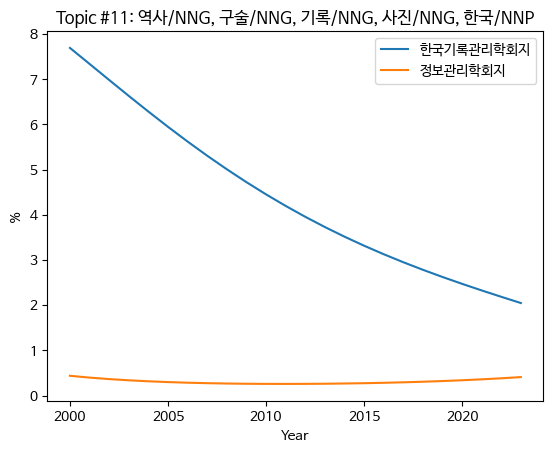

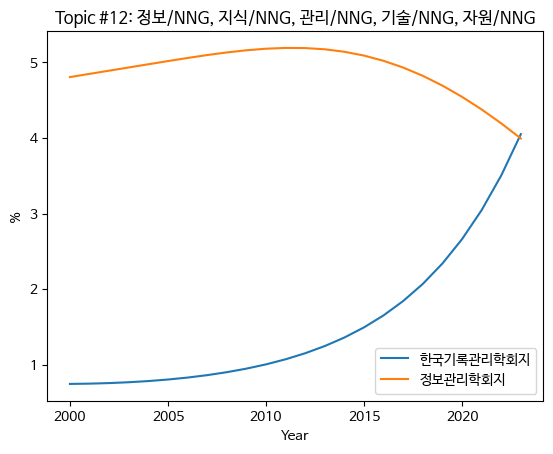

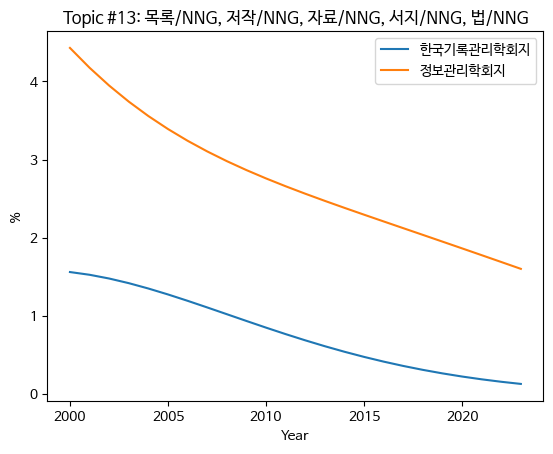

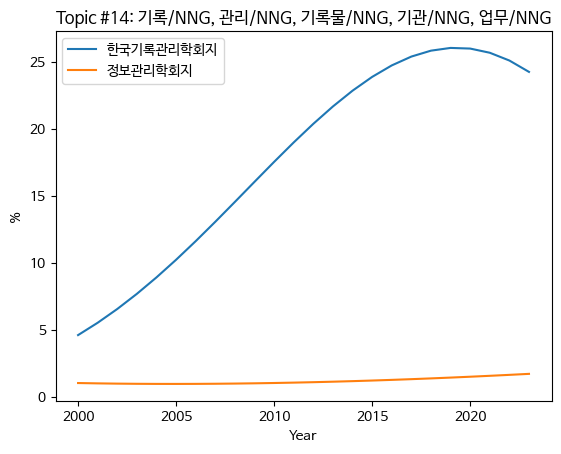

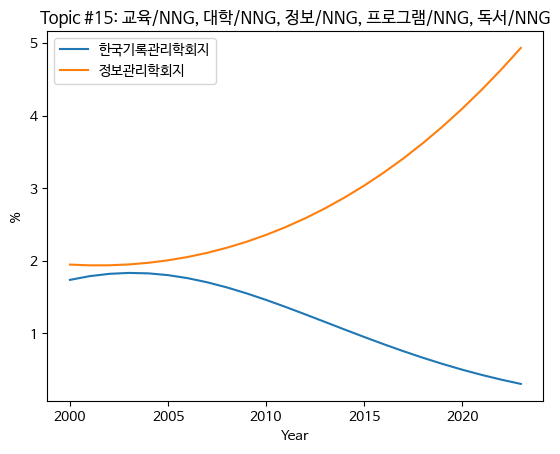

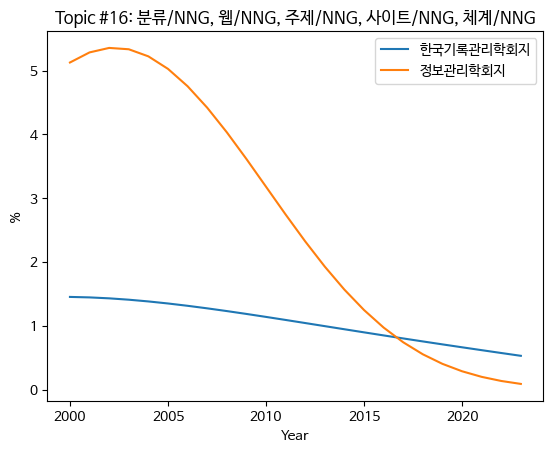

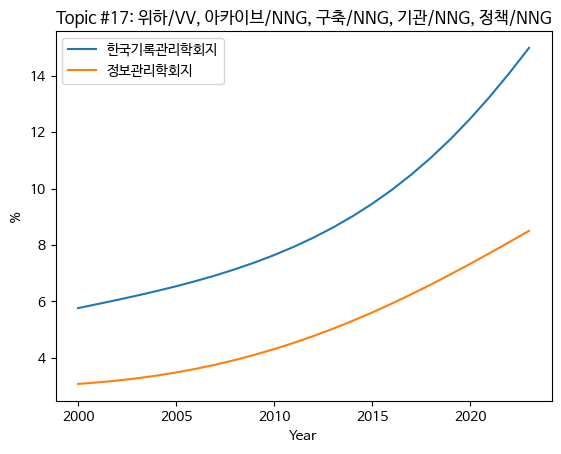

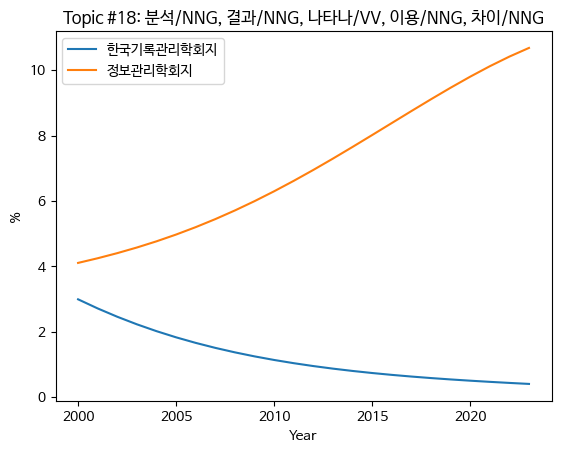

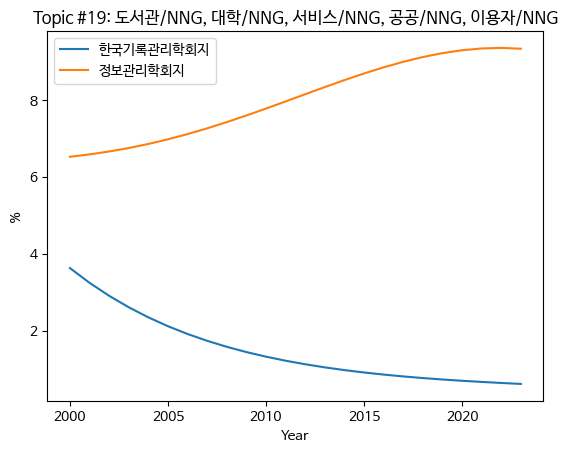

In [ ]:
years = np.linspace(start_year, end_year, end_year - start_year + 1)
for target_topic in range(model.k):
  for journal, y in zip(model.metadata_dict, dist_by_journal[:, :, target_topic]):
    plt.plot(years, y * 100, label=f"{journal}")

  plt.plot()
  plt.xlabel("Year")
  plt.ylabel("%")
  top5_words = model.get_topic_words(target_topic, top_n=5)
  title = ", ".join(word for word, _ in top5_words)
  plt.title(f"Topic #{target_topic}: {title}")
  plt.legend()
  plt.show()

# 모델링 결과를 엑셀 시트로 저장하기
학습 결과가 마음에 들어 저장해두고 싶다면 다시 엑셀 시트로 내보내는 것도 가능합니다. 기존의 lis_journal.xlsx에 문서별 주제 비율을 나타내는 열들을 추가하여 'lis_journal_with_topics.xlsx' 라고 저장하고, 또 각 주제별 단어 분포들은 'lis_journal_topic_word.xlsx' 라고 저장해봅시다.

In [ ]:
doc_topic = np.array([doc.get_topic_dist() for doc in model.docs])
for i, probs in enumerate(doc_topic.T):
  df[f'Topic #{i}'] = probs

In [ ]:
df.to_excel('lis_journal_with_topics.xlsx')

In [ ]:
# 각 주제별로 상위 50개 단어를 출력하여 엑셀로 저장합니다.
topic_word_data = {}
for k in range(model.k):
  word_forms, word_probs = zip(*model.get_topic_words(k, top_n=50))
  topic_word_data[f'#{k}'] = word_forms
  topic_word_data[f'#{k} prob'] = word_probs

topic_word_df = pd.DataFrame(data=topic_word_data)

In [ ]:
topic_word_df.to_excel('lis_journal_topic_word.xlsx')

In [ ]:
# 각 저널/연도별 주제 분포도 엑셀로 저장합시다.
journal_year_data = {}
journal_year_data['Year'] = years
for target_topic in range(model.k):
  for journal, y in zip(model.metadata_dict, dist_by_journal[:, :, target_topic]):
    journal_year_data[f'#{target_topic} @ {journal}'] = y

journal_year_df = pd.DataFrame(data=journal_year_data)

In [ ]:
journal_year_df.to_excel('lis_journal_topic_year.xlsx')